<a href="https://colab.research.google.com/github/Romal27/DSGP-24-Retina94/blob/Validating-the-input/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import os
import cv2
import numpy as np
from hashlib import md5
import matplotlib.pyplot as plt
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectFromModel
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE

In [18]:
source_base_path = "D:/Datasets_Retina"
fundus_path = os.path.join(source_base_path, "Fundus")
non_fundus_path = os.path.join(source_base_path, "Non Fundus")
save_base_path = "D:/Processed_New" 
save_fundus_path = os.path.join(save_base_path, "Fundus")
save_non_fundus_path = os.path.join(save_base_path, "Non Fundus")

os.makedirs(save_fundus_path, exist_ok=True)
os.makedirs(save_non_fundus_path, exist_ok=True)

# Image size for resizing
IMG_SIZE = (224, 224)

def preprocess_and_save(input_folder, output_folder):
    for img_name in os.listdir(input_folder):
        img_path = os.path.join(input_folder, img_name)

        img = cv2.imread(img_path)
        if img is None:
            print(f"Skipping: {img_name} (Invalid image)")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        img = cv2.resize(img, IMG_SIZE)  # Resize
        img = img / 255.0  # Normalize to [0,1]

        save_path = os.path.join(output_folder, img_name)
        cv2.imwrite(save_path, (img * 255).astype(np.uint8))  # Convert back to 0-255 range for saving

    print(f" Preprocessed images saved in: {output_folder}")

# Process and save fundus images
preprocess_and_save(fundus_path, save_fundus_path)

# Process and save non-fundus images
preprocess_and_save(non_fundus_path, save_non_fundus_path)

print("\n All images preprocessed and saved successfully in D:/Processed_New!")


 Preprocessed images saved in: D:/Processed_New\Fundus
 Preprocessed images saved in: D:/Processed_New\Non Fundus

 All images preprocessed and saved successfully in D:/Processed_New!


In [19]:
def get_image_hash(img):
    """Compute MD5 hash for an image."""
    return md5(img.tobytes()).hexdigest()

def remove_duplicates(folder_path):
    image_hashes = set()
    duplicates = []
    
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        
        img = cv2.imread(img_path)
        if img is None:
            print(f"Skipping invalid image: {img_name}")
            continue
        
        img_hash = get_image_hash(img)
        
        if img_hash in image_hashes:
            print(f"Duplicate found: {img_name}, removing...")
            os.remove(img_path)
            duplicates.append(img_name)
        else:
            image_hashes.add(img_hash)
    
    print(f"Duplicate removal complete. {len(duplicates)} duplicates removed.")

# Remove duplicates from Fundus and Non Fundus
remove_duplicates("D:/Processed_New/Fundus")
remove_duplicates("D:/Processed_New/Non Fundus")



Duplicate found: 19e350c7c83c.png, removing...
Duplicate found: 1e143fa3de57.png, removing...
Duplicate found: 1f07dae3cadb.png, removing...
Duplicate found: 2b21d293fdf2.png, removing...
Duplicate found: 2c2aa057afc5.png, removing...
Duplicate found: 3044022c6969.png, removing...
Duplicate found: 33105f9b3a04.png, removing...
Duplicate found: 35aa7f5c2ec0.png, removing...
Duplicate found: 36ec36c301c1.png, removing...
Duplicate found: 38fe9f854046.png, removing...
Duplicate found: 3c53198519f7.png, removing...
Duplicate found: 3ca637fddd56.png, removing...
Duplicate found: 3e86335bc2fd.png, removing...
Duplicate found: 435d900fa7b2.png, removing...
Duplicate found: 4a44cc840ebe.png, removing...
Duplicate found: 51131b48f9d4.png, removing...
Duplicate found: 576e189d23d4.png, removing...
Duplicate found: 595446774178.png, removing...
Duplicate found: 5a36cea278ae.png, removing...
Duplicate found: 6165081b9021.png, removing...
Duplicate found: 63a03880939c.png, removing...
Duplicate fou

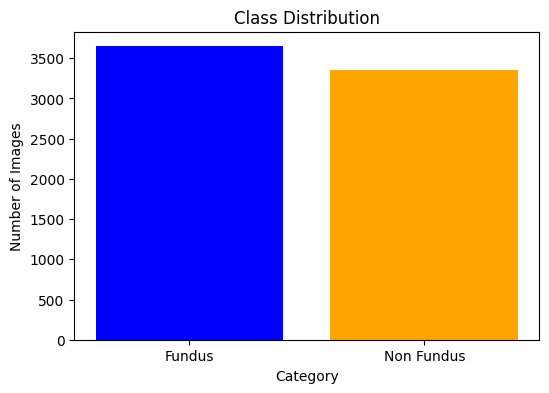

In [21]:
base_dir = "D:/Processed_New"
classes = ["Fundus", "Non Fundus"]

# Count images in each class
image_counts = {category: len(os.listdir(os.path.join(base_dir, category))) for category in classes}

plt.figure(figsize=(6, 4))
plt.bar(image_counts.keys(), image_counts.values(), color=['blue', 'orange'])
plt.xlabel("Category")
plt.ylabel("Number of Images")
plt.title("Class Distribution")
plt.show()


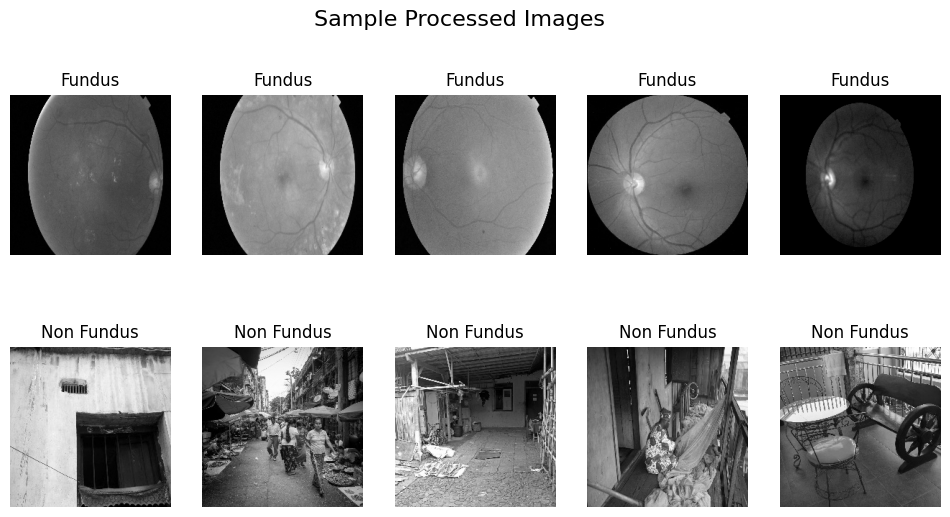

In [22]:
base_dir = "D:/Processed_New"
classes = ["Fundus", "Non Fundus"]
IMG_SIZE = (224, 224)

def load_images(folder_path, num_samples=5, randomize=False):
    img_list = os.listdir(folder_path)
    
    if randomize:
        random.shuffle(img_list)  # Shuffle for randomness
    
    images = []
    for img_name in img_list[:num_samples]:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, IMG_SIZE)
            images.append(img)
    return images

# Load images (shuffle only for Non Fundus)
sample_images = {
    "Fundus": load_images(os.path.join(base_dir, "Fundus")),
    "Non Fundus": load_images(os.path.join(base_dir, "Non Fundus"), randomize=True)
}

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle("Sample Processed Images", fontsize=16)

for i, category in enumerate(classes):
    for j in range(5):
        if j < len(sample_images[category]):
            axes[i, j].imshow(sample_images[category][j], cmap='gray')
            axes[i, j].set_title(f"{category}")
            axes[i, j].axis('off')

plt.show()


In [23]:
data_dir = "D:/Processed_New"
classes = ["Fundus", "Non Fundus"]
IMG_SIZE = (224, 224)
batch_size = 64

# Data augmentation (Only for training)
datagen = ImageDataGenerator(
    rotation_range=15,  # Reduced rotation to prevent excessive warping
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Reduced brightness range
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode="nearest"
)

# Function to preprocess images (Grayscale)
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
    if img is None:
        return None
    img = cv2.resize(img, IMG_SIZE)
    img = img.flatten()  # Flatten into a 1D feature vector
    return img

# Load and preprocess images
def load_and_preprocess_images():
    features, labels = [], []
    for label, category in enumerate(classes):
        folder_path = os.path.join(data_dir, category)
        img_paths = [os.path.join(folder_path, img) for img in os.listdir(folder_path)]
        for img_path in img_paths:
            img = preprocess_image(img_path)
            if img is not None:
                features.append(img)
                labels.append(label)
            if len(features) % 1000 == 0:
                print(f"Processed {len(features)} images...")
    return np.array(features), np.array(labels)

# Load dataset
X, y = load_and_preprocess_images()

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check class distribution
print("Train class distribution:", Counter(y_train))
print("Test class distribution:", Counter(y_test))

# Apply data augmentation (Only to training set)
X_train_augmented, y_train_augmented = [], []
for i in range(len(X_train)):
    img = np.reshape(X_train[i], (IMG_SIZE[0], IMG_SIZE[1], 1))  # Reshape for augmentation
    img = np.expand_dims(img, axis=0)  # Convert to batch format
    augmented_imgs = datagen.flow(img, batch_size=1)
    
    for _ in range(1):  # Reduce augmentation (was 2)
        aug_img = next(augmented_imgs)[0]  # Get augmented image
        X_train_augmented.append(aug_img.flatten())  # Flatten before storing
        y_train_augmented.append(y_train[i])

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

# Initialize Random Forest model with reduced overfitting
clf = RandomForestClassifier(
    n_estimators=100,  # Increased to 100 for better generalization
    max_depth=6,  # Reduced from 8 to 6 for shallower trees
    min_samples_split=20,  # Increased to 20 (was 10) for stronger regularization
    min_samples_leaf=8,  # Increased from 4 to 8 for fewer small splits
    random_state=42,
    class_weight='balanced'
)

# Train the model
clf.fit(X_train_augmented, y_train_augmented)

# Feature selection to remove unnecessary features
selector = SelectFromModel(clf, prefit=True, threshold="mean")
X_train_reduced = selector.transform(X_train_augmented)
X_test_reduced = selector.transform(X_test)

# Retrain with selected features
clf.fit(X_train_reduced, y_train_augmented)

# Evaluate model
y_pred = clf.predict(X_test_reduced)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Print classification report for detailed evaluation
print(classification_report(y_test, y_pred))


Processed 1000 images...
Processed 2000 images...
Processed 3000 images...
Processed 4000 images...
Processed 5000 images...
Processed 6000 images...
Train class distribution: Counter({np.int64(0): 2917, np.int64(1): 2680})
Test class distribution: Counter({np.int64(0): 730, np.int64(1): 670})
Test Accuracy: 0.9664
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       730
           1       1.00      0.93      0.96       670

    accuracy                           0.97      1400
   macro avg       0.97      0.97      0.97      1400
weighted avg       0.97      0.97      0.97      1400



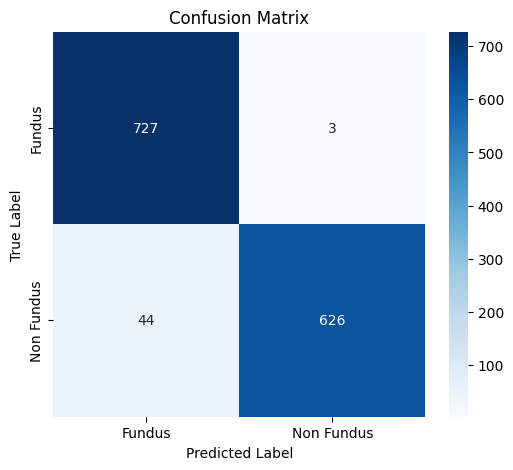

In [24]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


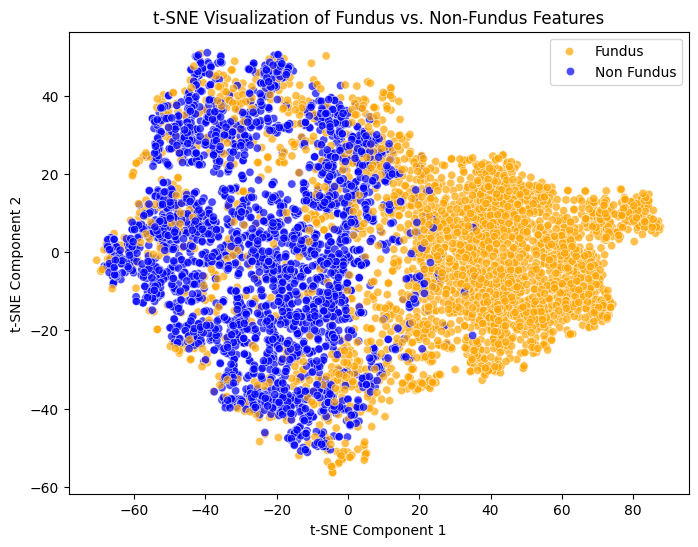

In [25]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
X_tsne = tsne.fit_transform(X_train_reduced)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_train_augmented, palette=['blue', 'orange'], alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of Fundus vs. Non-Fundus Features")
plt.legend(["Fundus", "Non Fundus"])
plt.show()


In [ ]:
import tensorflow as tf
print(tf.__version__) 

2.11.0


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix

# Ensure TensorFlow version compatibility
print(f"TensorFlow Version: {tf.__version__}")
assert tf.__version__.startswith("2.11"), "Please use TensorFlow 2.11.0"

# Define dataset directory
DATASET_PATH = "D:/Data1_split"
IMG_SIZE = 380  # EfficientNet-B4 default size
BATCH_SIZE = 32

# Image Data Generators (for loading and augmenting data)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    f"{DATASET_PATH}/Train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
validation_generator = val_test_datagen.flow_from_directory(
    f"{DATASET_PATH}/Validation",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
test_generator = val_test_datagen.flow_from_directory(
    f"{DATASET_PATH}/Test",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Load EfficientNet-B4 Model
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze base model

# Add custom classification layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)  # Prevent overfitting
x = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs=base_model.input, outputs=x)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit(
    train_generator,
    epochs=2,
    validation_data=validation_generator
)

model.save("tensor_classification_model")  # No extension needed
# Evaluate model on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

# Print training accuracy
train_acc = history.history['accuracy'][-1]
print(f"Final Training Accuracy: {train_acc:.4f}")

# Get predictions and classification report
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Non-Fundus', 'Fundus']))

# Plot confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, classes=['Non-Fundus', 'Fundus'])


TensorFlow Version: 2.11.0
Found 4931 images belonging to 2 classes.
Found 1056 images belonging to 2 classes.
Found 1059 images belonging to 2 classes.
Epoch 1/2
155/155 [==============================] - 882s 6s/step - loss: 0.6801 - accuracy: 0.5674 - val_loss: 0.6402 - val_accuracy: 0.6761
Epoch 2/2
155/155 [==============================] - 830s 5s/step - loss: 0.6517 - accuracy: 0.6437 - val_loss: 0.6049 - val_accuracy: 0.8324


TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [4]:
pip install matplotlib seaborn numpy tensorflow scikit-learn


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\User\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.
